In [1]:
from z3 import *
import numpy as np
import random
import arviz as az

import os, sys
sys.path.append(os.path.join("../../../"))

# our library
from src.mcmc_sat import smt,mcmc

## Model definition (in Z3)

We start by defining a model as an SMT problem using Z3

In [2]:
# We create five Integer variables
num_vars = 5
x = [Int(f'x{i}') for i in range(num_vars)]

In [3]:
# We define the model using the variables above

s = Solver() # get an instance of a Z3 solver

# model constraints
s.add(x[2]==30)
s.add(x[0]<=30)
s.add(x[1]<=30)
s.add(x[0]>=0)
s.add(x[1]>=0)
s.add(x[3]<=125)
s.add(x[4]<=125)
s.add(30<=x[3])
s.add(30<=x[4])
s.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5)

## Storing the model

We store the Z3 problem in a smt2 format. This is the input format required by Megasampler.

In [4]:
MEGASAMPLER_INPUT_DIR = 'megasampler_input'
megasampler_input_file = 'z3_problem.smt2'
megasampler_input_filepath = f'{MEGASAMPLER_INPUT_DIR}/{megasampler_input_file}'

smt.save_smt2(solver=s, filepath=megasampler_input_filepath)

## Executing Megasampler

Now we execute megasampler to produce 10000 samples (by default). The input to the function is the file where the smt2 version of the Z3 problem is stored.

In [5]:
# We execute megasampler \o/
MEGASAMPLER_OUTPUT_DIR = 'megasampler_output'
smt.execute_megasampler(input_filepath=megasampler_input_filepath,
                        output_dir=MEGASAMPLER_OUTPUT_DIR)

Parsing input file: megasampler_input/z3_problem.smt2
Number of formulas in file: 10
-------------FORMULA STATISTICS-------------
Arrays 0
Bit-vectors 0
Bools 0
Bits 0
Uninterpreted functions 0
Ints 5
Reals 0
Formula tree depth 5
--------------------------------------------
starting MeGASampler


Formula is satisfiable
---------SOLVING STATISTICS--------
do_epoch time: 128.309
epoch time: 265.07
grow_seed time: 4.0541
initial_solving time: 0.00372457
output time: 0.664071
start_epoch time: 136.704
total time: 265.102
Epochs: 29693
MAX-SMT calls: 29694
SMT calls: 0
Assignments considered (with repetitions): 3028585
Models (with repetitions): 3028585
Unique models (# samples in file): 10000
-----------------------------------


Megasampler stores the samples in a file. The file is stored in the directory passed as parameter in the above function. In what follows, we parse this file to produce a list of samples. Each sample is encoded as a dictionary where the key is the variable name and the value the sample.

In [6]:
# Define output files with samples
file_samples = f'{MEGASAMPLER_OUTPUT_DIR}/{megasampler_input_file}.samples'

In [7]:
# We parse the samples
samples = smt.parse_megasamples(file_samples)

## We run our MCMC algo

Finally, we run our MCMC algorithm. It takes as input the parsed samples. Currently, we always accept the samples. There is no likelihood or prior.

In [8]:
# We run MCMC using the "megasamples"
trace = mcmc.sample_mh_trace(10000,4,samples)

In [9]:
trace

Inference data with groups:
	> posterior

## Posterior

We conclude by showing the posterior trace plots and summary statistics for each variable.

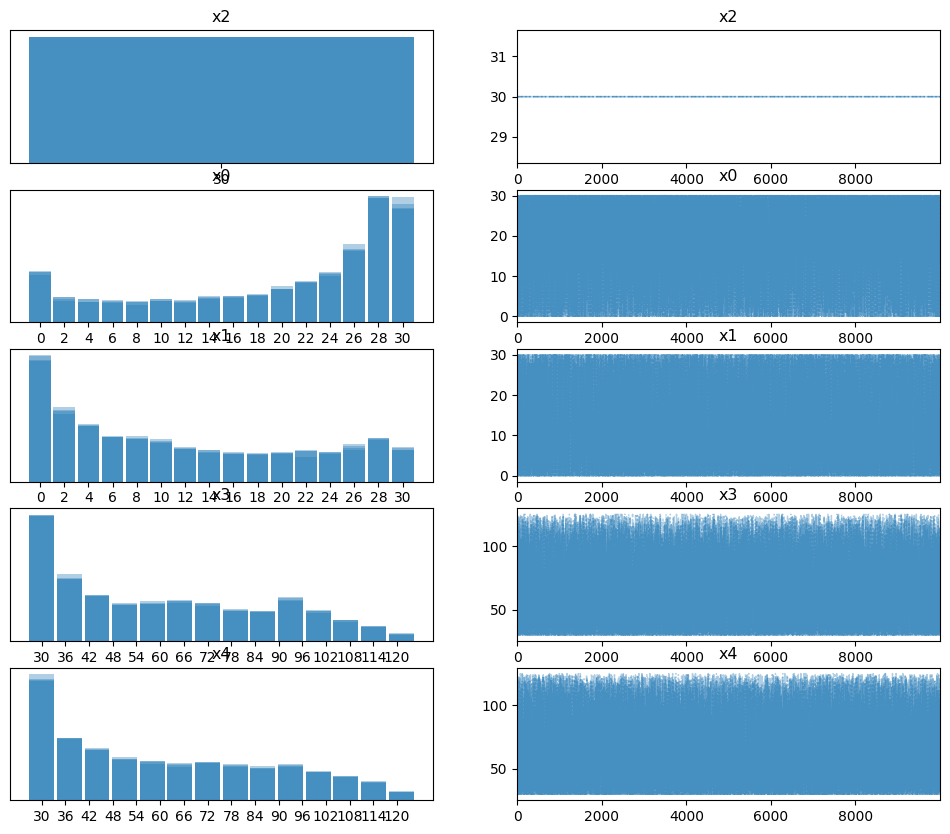

In [10]:
# Plot the posterior
import matplotlib.pyplot as plt
az.plot_trace(trace);
plt.savefig('megasampler_trace_plot.png', dpi=150);

In [11]:
# Diagnostics
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x2,30.000,0.000,30.0,30.0,0.000,0.000,40000.0,40000.0,NaN
x0,20.295,9.886,1.0,30.0,0.050,0.035,39102.0,40000.0,1.0
x1,12.168,10.020,0.0,29.0,0.051,0.036,38899.0,39691.0,1.0
x3,63.495,27.165,30.0,109.0,0.135,0.095,40687.0,40174.0,1.0
x4,64.008,27.372,30.0,111.0,0.138,0.098,39510.0,39793.0,1.0
